## Implementation of segmentation model with 1 class and identifier last layer
this ensures a regression output

To improve the model performance the height input is scaled using a MinMax scaling

In [ ]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
# change SM framework to tensorflow keras
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
# Set channels first, since the channels are the first dimension ( (2, 416, 704) for input, and (3, 416, 704) for output)
keras.backend.set_image_data_format('channels_first')

In [ ]:
# Import libraries
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [ ]:
# define the adjusted dataloader class
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
from torchvision.io import read_image

from sklearn.preprocessing import MinMaxScaler


class CustomImageDataset(Dataset):
    def __init__(self, label_dir, img_dir, annotation_dir, transform=None, target_transform=None):
        self.label_dir = label_dir
        self.annotations = pd.read_csv(annotation_dir, delimiter = ';') # to dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.target_shape = (416, 704)
    def __len__(self):
        return len(os.listdir(self.label_dir))
        #return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir #os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = pd.read_csv(img_path) #read_image(img_path)

        # Preprocess the input data

        #min_max_scaler = MinMaxScaler()
        #image['MinMaxScaled'] = min_max_scaler.fit_transform(image[['Y']])

        image = pd.DataFrame(image.MinMaxScaled.values.reshape(401, 701))
        # add padding to the image (needs to be dividable by 32)
        image = np.pad(image, ((0, 15), (0, 3)), mode='constant')
        wind_inlet_angle = self.annotations.iloc[idx, 0]
        wind_inlet_angle = np.full((416, 704), wind_inlet_angle)
        input_data = np.stack((image, wind_inlet_angle))

        label_path = os.path.join(self.label_dir, self.annotations.iloc[idx, 1]) # Maak csv met alle namen van bestanden (X en Y)
        label = pd.read_csv(label_path) #self.img_labels.iloc[idx, 1] # to di

        U_0 = label.loc[:, "U_0"]
        U_1 = label.loc[:, "U_1"]
        U_2 = label.loc[:, "U_2"]
        U_0 = pd.DataFrame(U_0.values.reshape(401, 701))
        U_1 = pd.DataFrame(U_1.values.reshape(401, 701))
        U_2 = pd.DataFrame(U_2.values.reshape(401, 701))

        U_0 = np.pad(U_0, ((0, 15), (0, 3)), mode='constant')
        U_1 = np.pad(U_1, ((0, 15), (0, 3)), mode='constant')
        U_2 = np.pad(U_2, ((0, 15), (0, 3)), mode='constant')

        output_data = np.stack((U_0, U_1, U_2))

        return input_data, output_data #image, label

In [ ]:
import keras
# Define some loss and metric for training. Just picked two random one that don't neccecarily make sense.
# Did this just to check if the package is generic for the different losses and metrics.
metric = keras.metrics.RootMeanSquaredError()
loss = keras.losses.MeanSquaredError()

In [ ]:
# Define the Unet model, for firs concept model I just picked the default backbone. Encoder weights to None since only 1 channel input.
# During the modelling I will test with conv layer as channel input to 3. (to utilize the weights)
backbone = 'resnet152'
model = Unet(backbone_name=backbone, encoder_weights=None, input_shape=(2, None, None), classes = 3, activation = 'linear')

# Compile the model with the different loss(es) and metric(s)
model.compile('Adam', loss=loss, metrics=[metric])

In [ ]:
# Save the callbacks, to later on save the model with best weights.
# Minumizing the loss so mode  = min
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# make the custom dataset
label_dir = '/content/drive/MyDrive/Thesis /Y-data 090524'
img_dir = '/content/drive/MyDrive/Thesis /X-data 090524/normal_surface_bed_original.txt_cut_trim.csv'
annotation_dir = '/content/drive/MyDrive/Thesis /X-data 090524/Annotations.csv'

dataset = CustomImageDataset(label_dir, img_dir, annotation_dir)

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [9, 2]) # Random split the dataset into train and test

In [ ]:
from torch.utils.data import DataLoader
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


In [ ]:
train_loader = Dataloder(dataset = train_set, batch_size = 2, shuffle=True)
test_loader = Dataloder(dataset = test_set)

In [ ]:
history = model.fit_generator(
    train_loader,
    steps_per_epoch=len(train_loader),
    epochs=100,
    callbacks=callbacks,
    validation_data=test_loader,
    validation_steps=len(test_loader)
)

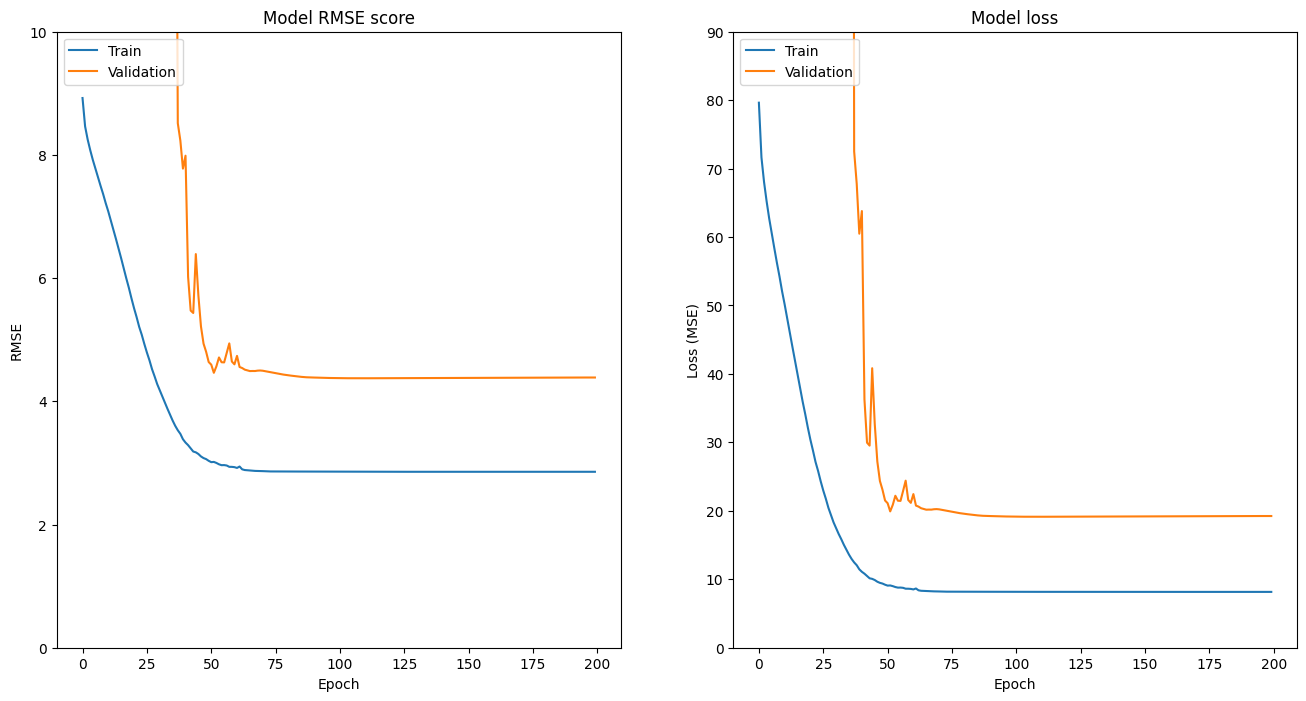

In [ ]:
import matplotlib.pyplot as plt

# Plot both root_mean_squared_error and loss in the same figure
plt.figure(figsize=(16, 8))

# Plot root_mean_squared_error
plt.subplot(121)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])  # Add validation RMSE
plt.title('Model RMSE score')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 10)  # Set y-axis limit to 70

# Plot loss (MSE)
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # Add validation loss
plt.title('Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 90)  # Set y-axis limit to 70

plt.show()

In [ ]:
prediction = model.predict(test_loader)

2/2 [==============================] - 5s 1s/step


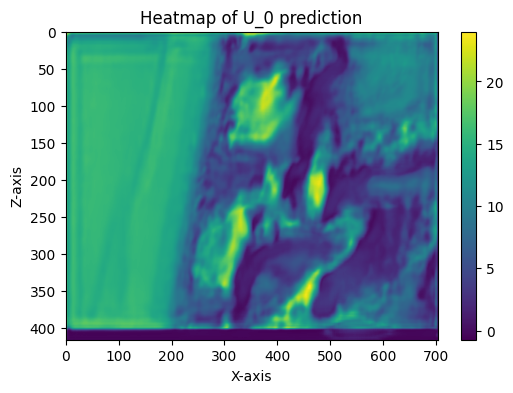

In [ ]:
plot_values = prediction[0][0]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of U_0 prediction')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

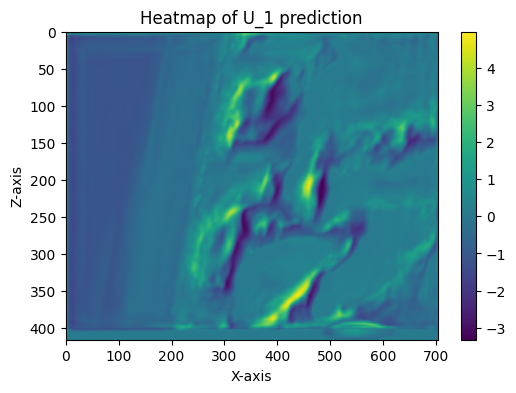

In [ ]:
plot_values = prediction[0][1]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of U_1 prediction')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

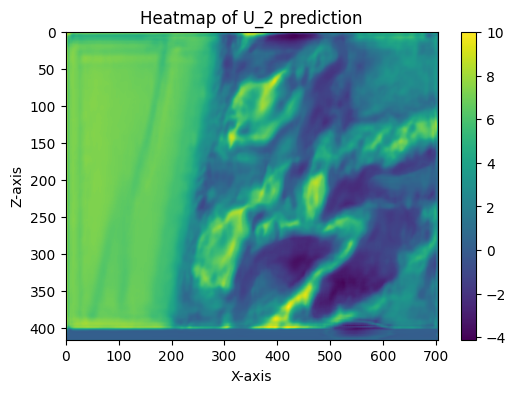

In [ ]:
plot_values = prediction[0][2]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of U_2 prediction')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

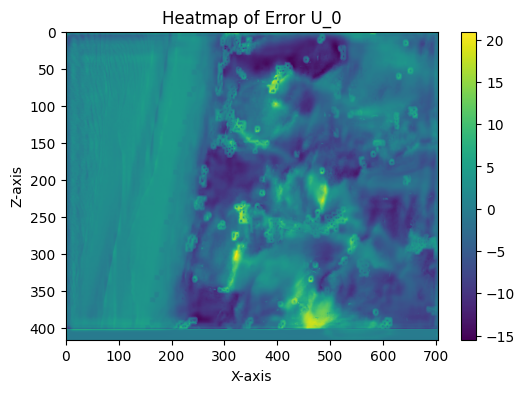

In [ ]:
plot_values = prediction[0][0] - test_set[0][1][0]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of Error U_0')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

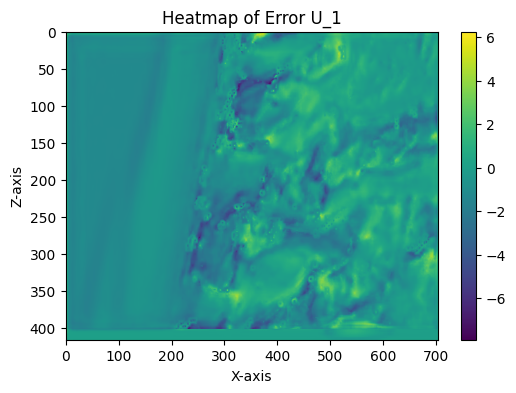

In [ ]:
plot_values = prediction[0][1] - test_set[0][1][1]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of Error U_1')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

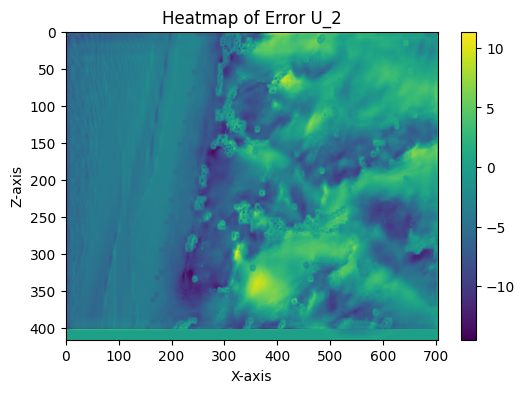

In [ ]:
plot_values = prediction[0][2] - test_set[0][1][2]
# Plot the heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.imshow(plot_values, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis')
plt.colorbar()  # Add a colorbar
plt.title('Heatmap of Error U_2')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.show()

In [ ]:
# Calculate the different RMSE
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse_value_0 = np.sqrt(mean_squared_error(test_set[0][1][0], prediction[0][0]))
rmse_value_1 = np.sqrt(mean_squared_error(test_set[0][1][1], prediction[0][1]))
rmse_value_2 = np.sqrt(mean_squared_error(test_set[0][1][2], prediction[0][2]))
print(f"""RMSE_0: {rmse_value_0:.4f},
RMSE_1: {rmse_value_1:.4f},
RMSE_2: {rmse_value_2:.4f}
""")

RMSE_0: 4.8095,
RMSE_1: 1.2522,
RMSE_2: 4.5128

